**TODO:**
- More Notebooks, it gets too messy.
- More than 1 experiments incl. vizs
- Repeat the experiments 100 times (for random noise). With 4 Points and with all points. H: 4 Points should be worse?! **(!!!)**
- Pixel Density + Noise experiment: Pixel Density low -> noise influence high
- Area -> Z = 0 am besten durchgemittelt. Welche hoehe man waehlt mit 4 von x punkten wichtig. Deswegen je mehr punkte desto bessere nicht reale hoehe annehmbar.

## Function Definitions

#### Overall

In [58]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'grid'])

# Globals
SCALING_FACTOR = 54.67 # x PX = 1M

In [2]:
def load_data(filename):
    out = {}
    with open(filename, 'r') as file:
        for line in file:
            name, x, y = line.split()
            out[name] = (float(x), float(y))
    return out

def load_dataset(pv_img, tv_img):
    validation_pts_tv = load_data(f'data/annotations/{tv_img}_blue.txt')
    validation_pts_pv = load_data(f'data/annotations/{pv_img}_blue.txt')
    reference_pts_tv = load_data(f'data/annotations/{tv_img}_white.txt')
    reference_pts_pv = load_data(f'data/annotations/{pv_img}_white.txt')
    # Slice TV points 
    validation_pts_tv = {k: validation_pts_tv[k] for k in validation_pts_pv}
    reference_pts_tv = {k: reference_pts_tv[k] for k in reference_pts_pv}
    return reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv

In [3]:
def get_images(pv_img, tv_img):
    pv_name = f'data/images/{pv_img}.JPG'
    tv_name = f'data/images/{tv_img}.JPG'
    return cv2.cvtColor(cv2.imread(pv_name), cv2.COLOR_BGR2RGB), cv2.cvtColor(cv2.imread(tv_name), cv2.COLOR_BGR2RGB)

In [4]:
def to_array(l):
    return np.array([[l[d][0], l[d][1]] for d in l])

def get_numpy_arr(pts):
    pts_arr = to_array(pts)
    homogeneous_c = np.ones((pts_arr.shape[0], 1))
    return np.hstack((pts_arr, homogeneous_c))

# Transform list to homogeneous numpy array
def transform_points(reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv):
    reference_pts_pv_arr = get_numpy_arr(reference_pts_pv)
    reference_pts_tv_arr = get_numpy_arr(reference_pts_tv)
    validation_pts_pv_arr = get_numpy_arr(validation_pts_pv)
    validation_pts_tv_arr = get_numpy_arr(validation_pts_tv)
    return reference_pts_pv_arr, reference_pts_tv_arr, validation_pts_pv_arr, validation_pts_tv_arr

In [5]:
# Transform reference points to Top View
def predict(pts, h):
    pred_pts = h@pts.T
    return (pred_pts / pred_pts[2]).T

In [6]:
def plot_setup(img_tv, img_pv, reference_result_dict, validation_result_dict):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Reference- and Validation Points w Pixel Density')
    axs[1].imshow(img_tv)
    axs[0].imshow(img_pv)
    axs[0].axis('off')
    axs[1].axis('off')
    # Reference Points
    x_offset = -300
    y_offset = +200
    for name, pt in reference_result_dict.items():
        axs[0].plot(pt['coordinates_pv'][0], pt['coordinates_pv'][1], marker='X', color='whitesmoke', markersize=8)
        axs[0].annotate(f'{pt["pixel_density"]:.2f}', 
                        xy=(pt['coordinates_pv'][0]+x_offset, pt['coordinates_pv'][1]+y_offset),
                        bbox=dict(facecolor='whitesmoke', edgecolor='white', boxstyle="round", alpha=0.8))
        axs[1].plot(pt['coordinates_tv'][0], pt['coordinates_tv'][1], marker='X', color='whitesmoke', markersize=8)
        
    # Validation Points
    for name, pt in validation_result_dict.items():
        axs[0].plot(pt['coordinates_pv'][0], pt['coordinates_pv'][1], marker='X', color='steelblue', markersize=8)
        axs[0].annotate(f'{pt["pixel_density"]:.2f}', 
                        xy=(pt['coordinates_pv'][0]+x_offset, pt['coordinates_pv'][1]+y_offset),
                        bbox=dict(facecolor='steelblue', edgecolor='royalblue', boxstyle="round", alpha=0.8),
                        color='white')
        axs[1].plot(pt['coordinates_tv'][0], pt['coordinates_tv'][1], marker='X', color='steelblue', markersize=8)  
    plt.subplots_adjust(bottom=0, wspace=0)
    plt.show()

In [7]:
def plot_predictions(img_tv, img_pv, reference_result_dict, validation_result_dict):
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    fig.suptitle('Reference- and Validation Points, their Predictions, and Error')
    ax.imshow(img_tv)
    ax.axis('off')
    x_offset = -150
    y_offset = +200
    # Reference Points
    for name, pt in reference_result_dict.items():
        ax.plot(pt['coordinates_tv'][0], pt['coordinates_tv'][1], marker='X', color='whitesmoke', markersize=8)
        ax.plot(pt['predicted_coordinates_tv'][0], pt['predicted_coordinates_tv'][1], marker='X', color='lightsalmon', markersize=8)
        ax.annotate(f'{pt["error"]:.2f}', 
                    xy=(pt['coordinates_tv'][0]+x_offset, pt['coordinates_tv'][1]+y_offset),
                    bbox=dict(facecolor='whitesmoke', edgecolor='white', boxstyle="round", alpha=0.8))
        
    # Validation Points
    for name, pt in validation_result_dict.items():
        ax.plot(pt['coordinates_tv'][0], pt['coordinates_tv'][1], marker='X', color='steelblue', markersize=8)  
        ax.plot(pt['predicted_coordinates_tv'][0], pt['predicted_coordinates_tv'][1], marker='X', color='cyan', markersize=8)
        ax.annotate(f'{pt["error"]:.2f}', 
                    xy=(pt['coordinates_tv'][0]+x_offset, pt['coordinates_tv'][1]+y_offset),
                    bbox=dict(facecolor='steelblue', edgecolor='royalblue', boxstyle="round", alpha=0.8),
                    color='white')
    plt.show()

In [8]:
# Calculate Errors
def calculate_error(pred_pts, gt_pts):
    return np.mean([np.linalg.norm(pred-gt) for pred, gt in zip(pred_pts[:, :2], gt_pts[:, :2])])

def print_errors(predicted_reference_pts_tv, reference_pts_tv_arr, predicted_validation_pts_tv, validation_pts_tv_arr):
    print(f'Reference  Error: {calculate_error(predicted_reference_pts_tv, reference_pts_tv_arr) :.2f} PX!')
    print(f'Validation Error: {calculate_error(predicted_validation_pts_tv, validation_pts_tv_arr):.2f} PX!')
    print('---')
    print(f'Reference  Error: {calculate_error(predicted_reference_pts_tv, reference_pts_tv_arr) / SCALING_FACTOR * 100 :.2f} CM!')
    print(f'Validation Error: {calculate_error(predicted_validation_pts_tv, validation_pts_tv_arr)/ SCALING_FACTOR * 100 :.2f} CM!')

def calculate_errors(pred_pts, gt_pts):
    return [np.linalg.norm(pred-gt) for pred, gt in zip(pred_pts[:, :2], gt_pts[:, :2])]

def get_result_dict(point_dict_pv, point_arr_tv, predicted_points_tv, errors, densities):
    error_dict = {}
    for i, (name, coord) in enumerate(point_dict_pv.items()):
        error_dict[name] = {}
        error_dict[name]['coordinates_pv'] = coord
        error_dict[name]['coordinates_tv'] = (point_arr_tv[i][0], point_arr_tv[i][1])
        error_dict[name]['predicted_coordinates_tv'] = (predicted_points_tv[i][0], predicted_points_tv[i][1])
        error_dict[name]['error'] = errors[i]
        error_dict[name]['pixel_density'] = densities[i]
    return error_dict

In [9]:
# Get Point Density
def get_surrounding_points(point):
    point_right, point_left, point_up, point_down = point.copy(), point.copy(), point.copy(), point.copy()
    point_right[0] += 2*SCALING_FACTOR
    point_left[0] -= 2*SCALING_FACTOR
    point_up[1] += 2*SCALING_FACTOR
    point_down[1] -= 2*SCALING_FACTOR
    return point_right, point_left, point_up, point_down

def get_point_density(point, h_inv):
    point_right, point_left, point_up, point_down = get_surrounding_points(point)
    # Predict
    points = np.vstack((point, point_right, point_left, point_up, point_down))
    predicted_points = predict(points, h_inv)
    dists = []
    for surrounding_point in predicted_points[1:]:
        dists.append(np.linalg.norm(predicted_points[0,:2] - surrounding_point[:2]))
    return np.mean(dists)

def get_densities(points, h_inv):
    densities = []
    for pt in points: 
        densities.append(get_point_density(pt, h_inv))
    return densities

#### Noise

In [10]:
def add_noise(points, m=0, std=1):
    zeros = np.zeros((points.shape[0], 1))
    noise = np.random.normal(m, std, points[:,:-1].shape)
    noise = np.hstack((noise, zeros))
    return points + noise

def get_result_dict_noised(point_dict_pv, point_arr_tv, predicted_points_tv, errors, densities, point_arr_pv_noised, point_arr_tv_noised):
    error_dict = {}
    for i, (name, coord) in enumerate(point_dict_pv.items()):
        error_dict[name] = {}
        error_dict[name]['coordinates_pv'] = coord
        error_dict[name]['coordinates_tv'] = (point_arr_tv[i][0], point_arr_tv[i][1])
        error_dict[name]['coordinates_pv_noised'] = (point_arr_pv_noised[i][0], point_arr_pv_noised[i][1])
        error_dict[name]['coordinates_tv_noised'] = (point_arr_tv_noised[i][0], point_arr_tv_noised[i][1])
        error_dict[name]['predicted_coordinates_tv'] = (predicted_points_tv[i][0], predicted_points_tv[i][1])
        error_dict[name]['error'] = errors[i]
        error_dict[name]['pixel_density'] = densities[i]
    return error_dict

def plot_setup_noised(img_tv, img_pv, reference_result_dict, validation_result_dict):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    plt.subplots_adjust(bottom=0, wspace=0)
    axs[0].imshow(img_pv)
    axs[1].imshow(img_tv)
    axs[0].axis('off')
    axs[1].axis('off')
    for name, pt in reference_result_dict.items():          
        axs[0].plot(pt['coordinates_pv'][0], pt['coordinates_pv'][1], marker='X', color='whitesmoke', markersize=8)
        axs[0].plot(pt['coordinates_pv_noised'][0], pt['coordinates_pv_noised'][1], marker='X', color='tomato', markersize=8)
        axs[0].annotate("", xy=(pt['coordinates_pv_noised'][0], pt['coordinates_pv_noised'][1]), 
                    xytext=(pt['coordinates_pv'][0], pt['coordinates_pv'][1]),
                    #arrowprops=dict(facecolor='black'))
                    arrowprops=dict(arrowstyle="simple", facecolor='black'))
        axs[1].plot(pt['coordinates_tv'][0], pt['coordinates_tv'][1], marker='X', color='whitesmoke', markersize=8)
        axs[1].plot(pt['coordinates_tv_noised'][0], pt['coordinates_tv_noised'][1], marker='X', color='tomato', markersize=8)
        axs[1].annotate("", xy=(pt['coordinates_tv_noised'][0], pt['coordinates_tv_noised'][1]), 
                    xytext=(pt['coordinates_tv'][0], pt['coordinates_tv'][1]),
                    #arrowprops=dict(facecolor='black'))
                    arrowprops=dict(arrowstyle="simple", facecolor='black'))

#### Outlier

In [11]:
import random

def add_outlier(points, i, magnitude):
    points_ = points.copy()
    noise = np.random.normal(0, 10, 2)*magnitude
    points_[i, :2] = points_[i, :2] + noise 
    return points_# + noise

## Execute One Experiment

Reference  Error: 2.47 PX!
Reference  Error: 4.52 CM!
---
Validation Error: 34.93 PX!
Validation Error: 63.90 CM!


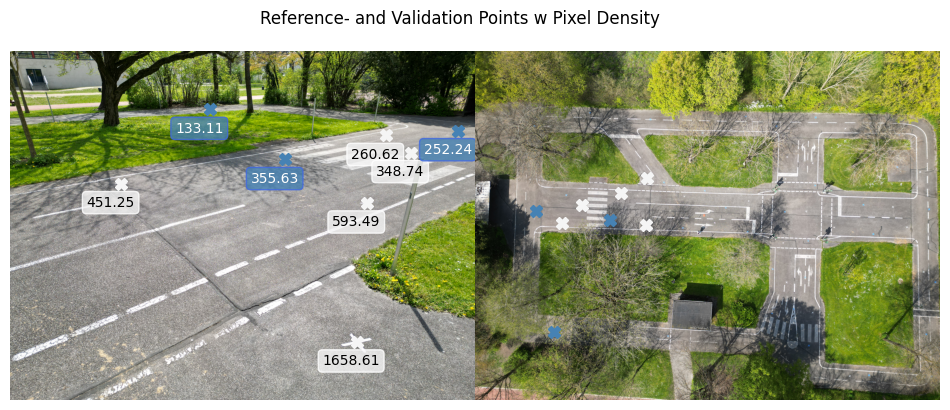

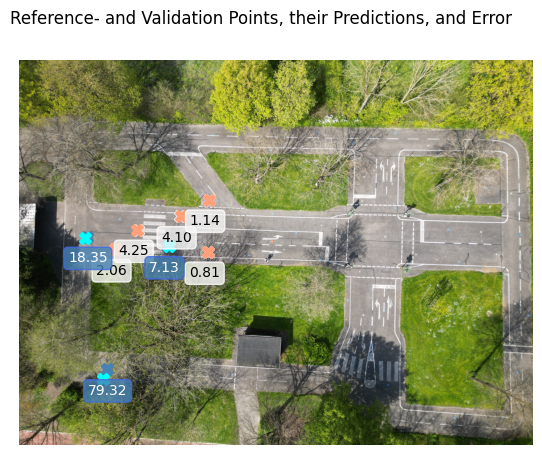

In [48]:
pv_img = 'DJI_0045'
tv_img = 'DJI_0017'

def conduct_experiment(pv_img, tv_img, plot=True, print_errors=True):
    # Load Data
    reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv = load_dataset(pv_img, tv_img)
    img_pv, img_tv = get_images(pv_img, tv_img)
    # Transform Points to Homogeneous Numpy arrays
    reference_pts_pv_arr, reference_pts_tv_arr, validation_pts_pv_arr, validation_pts_tv_arr = transform_points(
        reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv)
    # Calculate Homography
    h, _ = cv2.findHomography(
        reference_pts_pv_arr,
        reference_pts_tv_arr,
        # method = cv2.RANSAC,
        method = 0,
    )
    h_inv = np.linalg.inv(h)

    # Get Pixel Densities
    reference_densities = get_densities(reference_pts_tv_arr, h_inv)
    validation_densities = get_densities(validation_pts_tv_arr, h_inv)
    
    # Predict Points
    predicted_reference_pts_tv = predict(reference_pts_pv_arr, h)
    predicted_validation_pts_tv = predict(validation_pts_pv_arr, h)
    
    # Errors
    reference_errors = calculate_errors(predicted_reference_pts_tv, reference_pts_tv_arr)
    validation_errors = calculate_errors(predicted_validation_pts_tv, validation_pts_tv_arr)

    # Combine Results in Dictionary
    reference_result_dict = get_result_dict(reference_pts_pv, reference_pts_tv_arr, predicted_reference_pts_tv, reference_errors, reference_densities)
    validation_result_dict = get_result_dict(validation_pts_pv, validation_pts_tv_arr, predicted_validation_pts_tv, validation_errors, validation_densities)
    
    # Print Errors
    if print_errors:
        print(f'Reference  Error: {np.mean(reference_errors) :.2f} PX!')
        print(f'Reference  Error: {np.mean(reference_errors) / SCALING_FACTOR * 100 :.2f} CM!')
        print('---')
        print(f'Validation Error: {np.mean(validation_errors):.2f} PX!')
        print(f'Validation Error: {np.mean(validation_errors) / SCALING_FACTOR * 100 :.2f} CM!')
    
    # Plots
    if plot:
        plot_setup(img_tv, img_pv, reference_result_dict, validation_result_dict)
        plot_predictions(img_tv, img_pv, reference_result_dict, validation_result_dict)
    return reference_result_dict, validation_result_dict
reference_result_dict, validation_result_dict = conduct_experiment(pv_img, tv_img, plot=True)

#### Get Result Dict over images

In [122]:
# Get Raw Data Dict per image
def get_data_over_images(pv_imgs):
    for pv_img in pv_imgs:
        reference_result_dict, validation_result_dict = conduct_experiment(pv_img, tv_img, plot=False, print_errors=False)
        result[pv_img] = {}
        result[pv_img]['reference_result_dict'] = reference_result_dict
        result[pv_img]['validation_result_dict'] = validation_result_dict
    return result

result = get_data_over_images(['DJI_0026', 'DJI_0029', 'DJI_0032', 'DJI_0035', 'DJI_0038', 
                               'DJI_0045', 'DJI_0049', 'DJI_0053', 'DJI_0061', 'DJI_0066', 
                               'DJI_0067', 'DJI_0078'])
# pprint.pp(result)

#### Error wrt Density

**Hypothesis:** The higher the density, the less the effect of certain errors.

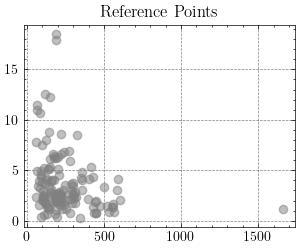

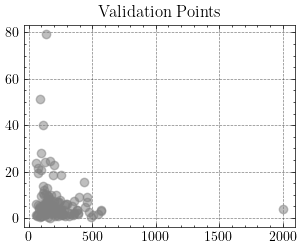

In [125]:
def get_density_error(result_dict):
    density_errors = []
    for pt, pt_dict in result_dict.items():
        density_errors.append([pt_dict['pixel_density'], pt_dict['error']])
    return density_errors

def get_density_errors(result_dict):
    reference_density_errors = []
    validation_density_errors = []
    for img, img_result_dict in result_dict.items():
        reference_density_errors+=get_density_error(img_result_dict['reference_result_dict'])
        validation_density_errors+=get_density_error(img_result_dict['validation_result_dict'])
    return np.array(reference_density_errors), np.array(validation_density_errors)

def plot_density(err_arr):
    plt.scatter(err_arr[:, 0], err_arr[:, 1], c='gray', alpha=0.5)

reference_density_errors, validation_density_errors = get_density_errors(result)

plot_density(reference_density_errors)
plt.title('Reference Points')
plt.show()
plot_density(validation_density_errors)
plt.title('Validation Points')
plt.show()

#### Error Distribution over images

Reference Points
DJI_0026: 1.83px, 3.35cm
DJI_0029: 3.58px, 6.56cm
DJI_0032: 1.92px, 3.51cm
DJI_0035: 2.94px, 5.39cm
DJI_0038: 3.37px, 6.16cm
DJI_0045: 2.47px, 4.52cm
DJI_0049: 4.22px, 7.72cm
DJI_0053: 10.93px, 19.99cm
DJI_0061: 3.17px, 5.80cm
DJI_0066: 2.48px, 4.53cm
DJI_0067: 2.94px, 5.39cm
DJI_0078: 4.44px, 8.12cm


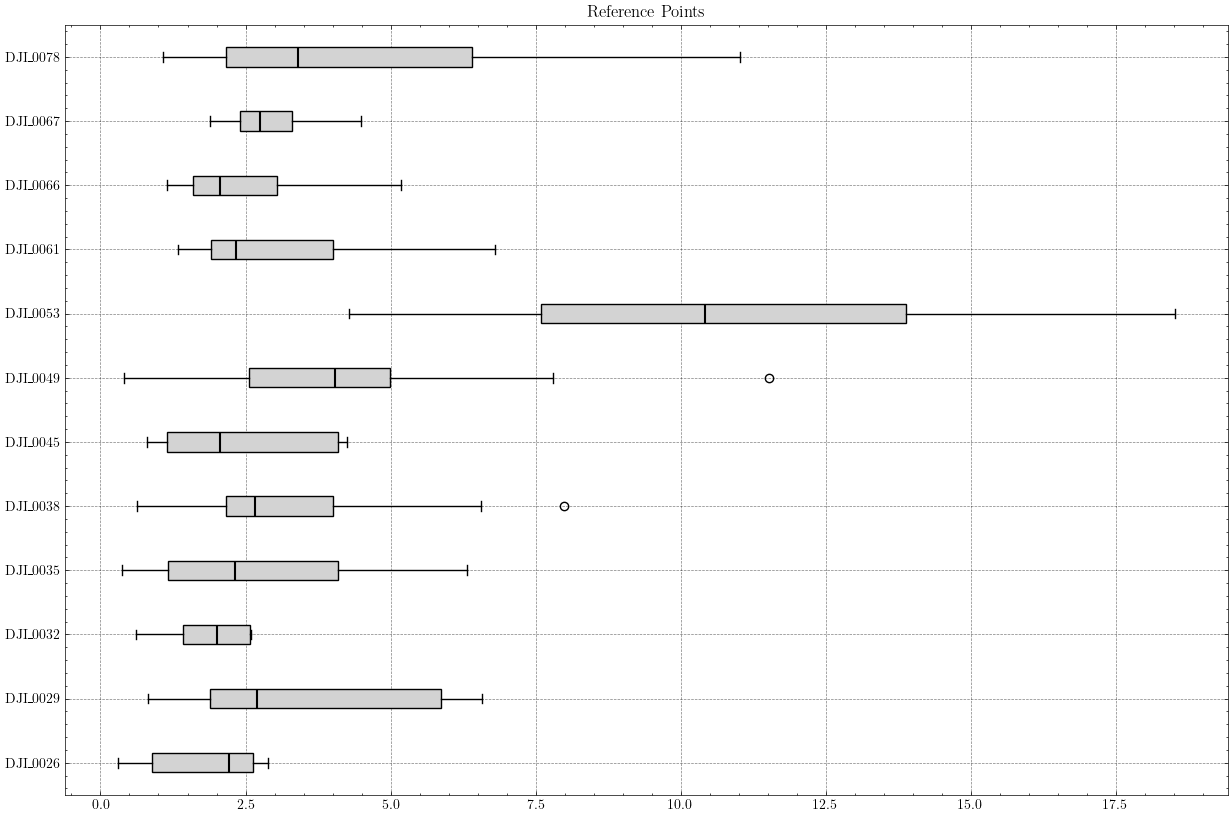


Validation Points
DJI_0026: 3.80px, 6.95cm
DJI_0029: 3.83px, 7.01cm
DJI_0032: 3.13px, 5.72cm
DJI_0035: 5.33px, 9.74cm
DJI_0038: 4.34px, 7.95cm
DJI_0045: 34.93px, 63.90cm
DJI_0049: 7.25px, 13.27cm
DJI_0053: 19.16px, 35.04cm
DJI_0061: 4.89px, 8.94cm
DJI_0066: 5.74px, 10.50cm
DJI_0067: 4.32px, 7.91cm
DJI_0078: 4.50px, 8.23cm


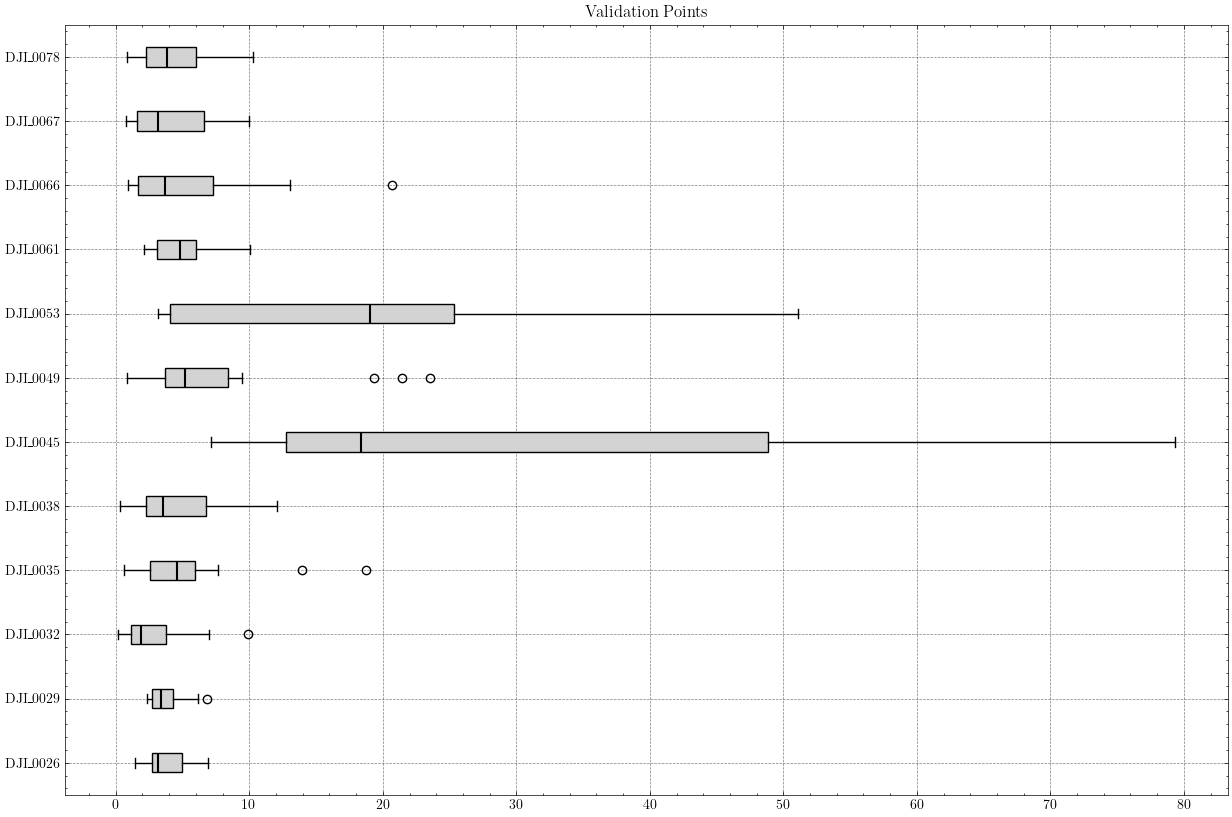

In [154]:
def get_img_error(img_dict):
    img_errors = []
    for pt, pt_dict in img_dict.items():
        img_errors.append(pt_dict['error'])
    return img_errors

def get_img_errors(result_dict):
    reference_img_errors = {}
    validation_img_errors = {}
    for img, img_result_dict in result_dict.items():
        reference_img_errors[img] = get_img_error(img_result_dict['reference_result_dict'])
        validation_img_errors[img] = get_img_error(img_result_dict['validation_result_dict'])
    reference_img_errors = dict(sorted(reference_img_errors.items()))
    validation_img_errors = dict(sorted(validation_img_errors.items()))
    return reference_img_errors, validation_img_errors

def print_errors(error_dict):
    for key in sorted(error_dict):
        print(f'{key}: {np.mean(error_dict[key]):.2f}px, {np.mean(error_dict[key])/ SCALING_FACTOR * 100:.2f}cm')

def plot_box(error_dict, ax):
    labels , data = error_dict.keys(), error_dict.values()
    ax.boxplot(data, labels=labels, vert=False, patch_artist=True, 
            boxprops=dict(facecolor='lightgray'), 
            medianprops=dict(color='black', lw=1.5),
            widths=0.3)

reference_img_errors, validation_img_errors = get_img_errors(result)
print('Reference Points') 
print_errors(reference_img_errors)
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plot_box(reference_img_errors, ax)
ax.set_title('Reference Points')
plt.show()

print()
print('Validation Points') 
print_errors(validation_img_errors)
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plot_box(validation_img_errors, ax)
ax.set_title('Validation Points')
plt.show()

## Conduct Experiment with random Noise

In [ ]:
pv_img = 'DJI_0026'
tv_img = 'DJI_0017'

def conduct_experiment_w_noise(pv_img, tv_img, plot=None):
    # Load Data
    reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv = load_dataset(pv_img, tv_img)
    reference_pts_pv_arr, reference_pts_tv_arr, validation_pts_pv_arr, validation_pts_tv_arr = transform_points(
            reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv)
    
    img_pv, img_tv = get_images(pv_img, tv_img)
    
    # Add Noise
    reference_pts_pv_arr_noised = add_noise(reference_pts_pv_arr, 0, 100)
    reference_pts_tv_arr_noised = add_noise(reference_pts_tv_arr, 0, 100)

    h, _ = cv2.findHomography(
        reference_pts_pv_arr_noised,
        reference_pts_tv_arr_noised,
        # method = cv2.RANSAC,
        method = 0,
    )
    h_inv = np.linalg.inv(h)

    # Get Pixel Densities
    reference_densities = get_densities(reference_pts_tv_arr, h_inv)
    validation_densities = get_densities(validation_pts_tv_arr, h_inv)
    
    # Predict Points
    predicted_reference_pts_tv = predict(reference_pts_pv_arr_noised, h)
    predicted_validation_pts_tv = predict(validation_pts_pv_arr, h) 

    # Errors
    reference_errors = calculate_errors(predicted_reference_pts_tv, reference_pts_tv_arr)
    validation_errors = calculate_errors(predicted_validation_pts_tv, validation_pts_tv_arr)

    # Combine Results in Dictionary
    reference_result_dict = get_result_dict_noised(reference_pts_pv, reference_pts_tv_arr, predicted_reference_pts_tv, reference_errors, reference_densities, reference_pts_pv_arr_noised, reference_pts_tv_arr_noised)
    validation_result_dict = get_result_dict(validation_pts_pv, validation_pts_tv_arr, predicted_validation_pts_tv, validation_errors, validation_densities)

    # Print Errors
    print(f'Reference  Error: {np.mean(reference_errors) :.2f} PX!')
    print(f'Reference  Error: {np.mean(reference_errors) / SCALING_FACTOR * 100 :.2f} CM!')
    print('---')
    print(f'Validation Error: {np.mean(validation_errors):.2f} PX!')
    print(f'Validation Error: {np.mean(validation_errors) / SCALING_FACTOR * 100 :.2f} CM!')

    # Plots
    if plot:
        plot_setup_noised(img_tv, img_pv, reference_result_dict, validation_result_dict)
        plot_predictions(img_tv, img_pv, reference_result_dict, validation_result_dict)
conduct_experiment_w_noise(pv_img, tv_img, plot=True)

## Conduct Experiment with n Outliers

In [ ]:
pv_img = 'DJI_0026'
tv_img = 'DJI_0017'
   
def conduct_experiment_w_outlier(pv_img, tv_img, plot=None):
    # Load Data
    reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv = load_dataset(pv_img, tv_img)
    reference_pts_pv_arr, reference_pts_tv_arr, validation_pts_pv_arr, validation_pts_tv_arr = transform_points(
            reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv)
    
    img_pv, img_tv = get_images(pv_img, tv_img)
    
    # Add Noise
    reference_pts_pv_arr_outlier = add_outlier(reference_pts_pv_arr, 2, 50)
    reference_pts_tv_arr_outlier = add_outlier(reference_pts_tv_arr, 2, 50)

    h, _ = cv2.findHomography(
        reference_pts_pv_arr_outlier,
        reference_pts_tv_arr_outlier,
        method = cv2.RANSAC,
        # method = 0,
    )
    h_inv = np.linalg.inv(h)

    # Get Pixel Densities
    reference_densities = get_densities(reference_pts_tv_arr, h_inv)
    validation_densities = get_densities(validation_pts_tv_arr, h_inv)
    
    # Predict Points
    predicted_reference_pts_tv = predict(reference_pts_pv_arr_outlier, h)
    predicted_validation_pts_tv = predict(validation_pts_pv_arr, h) 

    # Errors
    reference_errors = calculate_errors(predicted_reference_pts_tv, reference_pts_tv_arr)
    validation_errors = calculate_errors(predicted_validation_pts_tv, validation_pts_tv_arr)

    # Combine Results in Dictionary
    reference_result_dict = get_result_dict_noised(reference_pts_pv, reference_pts_tv_arr, predicted_reference_pts_tv, reference_errors, reference_densities, reference_pts_pv_arr_outlier, reference_pts_tv_arr_outlier)
    validation_result_dict = get_result_dict(validation_pts_pv, validation_pts_tv_arr, predicted_validation_pts_tv, validation_errors, validation_densities)

    # Print Errors
    print(f'Reference  Error: {np.mean(reference_errors) :.2f} PX!')
    print(f'Reference  Error: {np.mean(reference_errors) / SCALING_FACTOR * 100 :.2f} CM!')
    print('---')
    print(f'Validation Error: {np.mean(validation_errors):.2f} PX!')
    print(f'Validation Error: {np.mean(validation_errors) / SCALING_FACTOR * 100 :.2f} CM!')

    # Plots
    if plot:
        plot_setup_noised(img_tv, img_pv, reference_result_dict, validation_result_dict)
        plot_predictions(img_tv, img_pv, reference_result_dict, validation_result_dict)
conduct_experiment_w_outlier(pv_img, tv_img, plot=True)

#### TODOS

TODO: THIS RESULT IS WAY DIFFERENT!!! AND WAY TO GOOD ACTUALLY. ALL ERROR COMES FROM PX TO CM?!

Repeat the experiments 100 times (for random noise). With 4 Points and with all points. H: 4 Points should be worse?! **(!!!)**

## Collinearity in the Real World

In image **DJI_0026**, there is almost collinearity with 3 points! Those points are called: **w4, w5, w7**.

When I choose w4, w5, w7 and some other point is is really bad for validation points, and perfect for reference points.

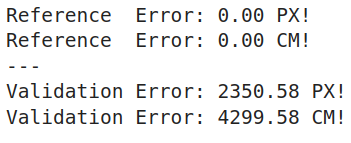

When I add another point, then it gets good again, because our optimization algorithm filters the bad one.


Now let's see how far i have to push the point to get better results. BUT HOW? PUSH 100 pixels in tv != PUSH 100 pixels in pv..

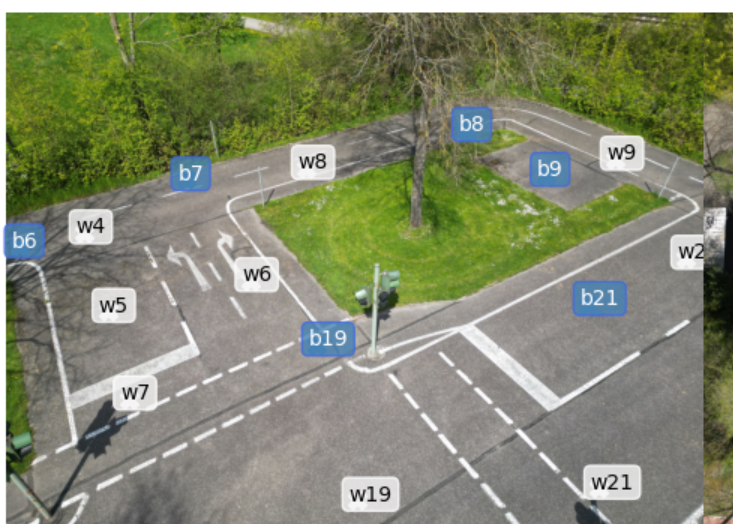

In [ ]:
3.83pv_img = 'DJI_0026'
tv_img = 'DJI_0017'

def filter_points(points, keys):
    filtered = {key: points[key] for key in keys}
    return filtered

def plot_names(img_tv, img_pv, reference_result_dict, validation_result_dict):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Reference- and Validation Points w Pixel Density')
    axs[1].imshow(img_tv)
    axs[0].imshow(img_pv)
    axs[0].axis('off')
    axs[1].axis('off')
    # Reference Points
    x_offset = -50
    y_offset = 0
    for name, pt in reference_result_dict.items():
        axs[0].plot(pt['coordinates_pv'][0], pt['coordinates_pv'][1], marker='X', color='whitesmoke', markersize=8)
        axs[0].annotate(name, 
                        xy=(pt['coordinates_pv'][0]+x_offset, pt['coordinates_pv'][1]+y_offset),
                        bbox=dict(facecolor='whitesmoke', edgecolor='white', boxstyle="round", alpha=0.8))
        axs[1].plot(pt['coordinates_tv'][0], pt['coordinates_tv'][1], marker='X', color='whitesmoke', markersize=8)
        
    # Validation Points
    for name, pt in validation_result_dict.items():
        axs[0].plot(pt['coordinates_pv'][0], pt['coordinates_pv'][1], marker='X', color='steelblue', markersize=8)
        axs[0].annotate(name, 
                        xy=(pt['coordinates_pv'][0]+x_offset, pt['coordinates_pv'][1]+y_offset),
                        bbox=dict(facecolor='steelblue', edgecolor='royalblue', boxstyle="round", alpha=0.8),
                        color='white')
        axs[1].plot(pt['coordinates_tv'][0], pt['coordinates_tv'][1], marker='X', color='steelblue', markersize=8)  
    plt.subplots_adjust(bottom=0, wspace=0)
    plt.show()

def add_outlier_directed(points, i, x, y):
    points_ = points.copy()
    points_[i, 0] += x
    points_[i, 1] += y
    return points_

def conduct_experiment(pv_img, tv_img, used_ref_points=None):
    # Load Data
    reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv = load_dataset(pv_img, tv_img)
    img_pv, img_tv = get_images(pv_img, tv_img)

    if used_ref_points:
        reference_pts_pv = filter_points(reference_pts_pv, used_ref_points)
        reference_pts_tv = filter_points(reference_pts_tv, used_ref_points)
    # validation_pts_pv = filter_points(validation_pts_pv)
    # validation_pts_tv = filter_points(validation_pts_tv)
    
    # Transform Points to Homogeneous Numpy arrays
    reference_pts_pv_arr, reference_pts_tv_arr, validation_pts_pv_arr, validation_pts_tv_arr = transform_points(
        reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv)

    # TODO SAME DIRECTION! THATS DUMB BECAUSE YOU CANT, 200 PIXELS IS NOT THE SAME IN TV AND PV
    reference_pts_pv_arr_outlier = add_outlier_directed(reference_pts_pv_arr, 1, -200, 0)
    reference_pts_tv_arr_outlier = add_outlier_directed(reference_pts_tv_arr, 1, -200, 0)
    
    # Calculate Homography
    h, _ = cv2.findHomography(
        reference_pts_pv_arr_outlier,
        reference_pts_tv_arr_outlier,
        # method = cv2.RANSAC,
        method = 0,
    )
    h_inv = np.linalg.inv(h)

    # Get Pixel Densities
    reference_densities = get_densities(reference_pts_tv_arr, h_inv)
    validation_densities = get_densities(validation_pts_tv_arr, h_inv)
    
    # Predict Points
    predicted_reference_pts_tv = predict(reference_pts_pv_arr, h)
    predicted_validation_pts_tv = predict(validation_pts_pv_arr, h)
    
    # Errors
    reference_errors = calculate_errors(predicted_reference_pts_tv, reference_pts_tv_arr)
    validation_errors = calculate_errors(predicted_validation_pts_tv, validation_pts_tv_arr)

    # Combine Results in Dictionary
    reference_result_dict = get_result_dict_noised(reference_pts_pv, reference_pts_tv_arr, predicted_reference_pts_tv, reference_errors, reference_densities, reference_pts_pv_arr_outlier, reference_pts_tv_arr_outlier)
    validation_result_dict = get_result_dict(validation_pts_pv, validation_pts_tv_arr, predicted_validation_pts_tv, validation_errors, validation_densities)
    
    # Print Errors
    print(f'Reference  Error: {np.mean(reference_errors) :.2f} PX!')
    print(f'Reference  Error: {np.mean(reference_errors) / SCALING_FACTOR * 100 :.2f} CM!')
    print('---')
    print(f'Validation Error: {np.mean(validation_errors):.2f} PX!')
    print(f'Validation Error: {np.mean(validation_errors) / SCALING_FACTOR * 100 :.2f} CM!')
    
    # Plots
    # plot_names(img_tv, img_pv, reference_result_dict, validation_result_dict)
    plot_setup_noised(img_tv, img_pv, reference_result_dict, validation_result_dict)
    # plot_predictions(img_tv, img_pv, reference_result_dict, validation_result_dict)..

conduct_experiment(pv_img, tv_img, ['w4', 'w5', 'w7', 'w6'])

## Different Point Compositions

In [ ]:
pv_img = 'DJI_0026'
tv_img = 'DJI_0017'

def filter_points(points, keys):
    filtered = {key: points[key] for key in keys}
    return filtered

def plot_names(img_tv, img_pv, reference_result_dict, validation_result_dict):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Reference- and Validation Points w Pixel Density')
    axs[1].imshow(img_tv)
    axs[0].imshow(img_pv)
    axs[0].axis('off')
    axs[1].axis('off')
    # Reference Points
    x_offset = -50
    y_offset = 0
    for name, pt in reference_result_dict.items():
        axs[0].plot(pt['coordinates_pv'][0], pt['coordinates_pv'][1], marker='X', color='whitesmoke', markersize=8)
        axs[0].annotate(name, 
                        xy=(pt['coordinates_pv'][0]+x_offset, pt['coordinates_pv'][1]+y_offset),
                        bbox=dict(facecolor='whitesmoke', edgecolor='white', boxstyle="round", alpha=0.8))
        axs[1].plot(pt['coordinates_tv'][0], pt['coordinates_tv'][1], marker='X', color='whitesmoke', markersize=8)
        
    # Validation Points
    for name, pt in validation_result_dict.items():
        axs[0].plot(pt['coordinates_pv'][0], pt['coordinates_pv'][1], marker='X', color='steelblue', markersize=8)
        axs[0].annotate(name, 
                        xy=(pt['coordinates_pv'][0]+x_offset, pt['coordinates_pv'][1]+y_offset),
                        bbox=dict(facecolor='steelblue', edgecolor='royalblue', boxstyle="round", alpha=0.8),
                        color='white')
        axs[1].plot(pt['coordinates_tv'][0], pt['coordinates_tv'][1], marker='X', color='steelblue', markersize=8)  
    plt.subplots_adjust(bottom=0, wspace=0)
    plt.show()

def add_outlier_directed(points, i, x, y):
    points_ = points.copy()
    points_[i, 0] += x
    points_[i, 1] += y
    return points_

def conduct_experiment(pv_img, tv_img, used_ref_points=None):
    # Load Data
    reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv = load_dataset(pv_img, tv_img)
    img_pv, img_tv = get_images(pv_img, tv_img)

    if used_ref_points:
        reference_pts_pv = filter_points(reference_pts_pv, used_ref_points)
        reference_pts_tv = filter_points(reference_pts_tv, used_ref_points)
    # validation_pts_pv = filter_points(validation_pts_pv)
    # validation_pts_tv = filter_points(validation_pts_tv)
    
    # Transform Points to Homogeneous Numpy arrays
    reference_pts_pv_arr, reference_pts_tv_arr, validation_pts_pv_arr, validation_pts_tv_arr = transform_points(
        reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv)
 
    # Calculate Homography
    h, _ = cv2.findHomography(
        reference_pts_pv_arr,
        reference_pts_tv_arr,
        # method = cv2.RANSAC,
        method = 0,
    )
    h_inv = np.linalg.inv(h)

    # Get Pixel Densities
    reference_densities = get_densities(reference_pts_tv_arr, h_inv)
    validation_densities = get_densities(validation_pts_tv_arr, h_inv)
    
    # Predict Points
    predicted_reference_pts_tv = predict(reference_pts_pv_arr, h)
    predicted_validation_pts_tv = predict(validation_pts_pv_arr, h)
    
    # Errors
    reference_errors = calculate_errors(predicted_reference_pts_tv, reference_pts_tv_arr)
    validation_errors = calculate_errors(predicted_validation_pts_tv, validation_pts_tv_arr)

    # Combine Results in Dictionary
    reference_result_dict = get_result_dict(reference_pts_pv, reference_pts_tv_arr, predicted_reference_pts_tv, reference_errors, reference_densities)
    validation_result_dict = get_result_dict(validation_pts_pv, validation_pts_tv_arr, predicted_validation_pts_tv, validation_errors, validation_densities)
    
    # Print Errors
    print(f'Reference  Error: {np.mean(reference_errors) :.2f} PX!')
    print(f'Reference  Error: {np.mean(reference_errors) / SCALING_FACTOR * 100 :.2f} CM!')
    print('---')
    print(f'Validation Error: {np.mean(validation_errors):.2f} PX!')
    print(f'Validation Error: {np.mean(validation_errors) / SCALING_FACTOR * 100 :.2f} CM!')
    
    # Plots
    plot_names(img_tv, img_pv, reference_result_dict, validation_result_dict)
    # plot_setup(img_tv, img_pv, reference_result_dict, validation_result_dict)
    # plot_predictions(img_tv, img_pv, reference_result_dict, validation_result_dict)..
from itertools import combinations
all_reference_points = ['w4', 'w5', 'w7', 'w6', 'w8', 'w19', 'w9', 'w22', 'w21']
for i, subset in enumerate(combinations(all_reference_points, 4)):
    print(f'Experiment {i}')
    conduct_experiment(pv_img, tv_img, subset)
    print('----------')
    break
#used_reference_points = 
#conduct_experiment(pv_img, tv_img)

# TODO EXPERIMENTS AS DICT AND THEN VIZ

# BETTER HOMOGRAPHY

In [ ]:
import torch
import torch.nn as nn


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 2)
        )
        
    def forward(self, x):
        print(x)
        # convert tensor (128, 1, 28, 28) --> (128, 1*28*28)
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x


mlp = MLP()
EPOCHS = 100


reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv = load_dataset(pv_img, tv_img)
reference_pts_pv_arr, reference_pts_tv_arr, validation_pts_pv_arr, validation_pts_tv_arr = transform_points(
    reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv)
X = np.vstack((reference_pts_pv_arr, validation_pts_pv_arr))[:, :2]

Y = np.vstack((reference_pts_tv_arr, validation_pts_tv_arr))[:, :2]
x_train = X[:-2]
y_train = Y[:-2]

x_test = X[-2:]
y_test = X[-2:]



#x_train, x_test, y_train, y_test = train_test_split(
#    X, Y, test_size=0.1, random_state=2)

mlpr = MLPRegressor()
mlpr.fit(x_train, y_train)
y_pred = mlpr.predict(x_test)



x_train = X[:-2]
y_train = Y[:-2]
x_test = X[-2:]
y_test = Y[-2:]

#x_train = X
#y_train = Y
#x_test = X
#y_test = Y


x_train = torch.from_numpy(x_train).type(torch.float32)
y_train = torch.from_numpy(y_train).type(torch.float32)
x_test = torch.from_numpy(x_test).type(torch.float32)
y_test = torch.from_numpy(y_test).type(torch.float32)

x_train[:, 0] = x_train[:, 0] / 4000
x_train[:, 1] = x_train[:, 1] / 3000
y_train[:, 0] = y_train[:, 0] / 4000
y_train[:, 1] = y_train[:, 1] / 3000
x_test[:, 0] = x_test[:, 0] / 4000
x_test[:, 1] = x_test[:, 1] / 3000


x_train2 = x_train

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 2)
        )
        
    def forward(self, x):
        # print(x)
        x = self.layers(x)
        return x

def loss_fn(a, b):
    return torch.sqrt(torch.sum(torch.pow(torch.subtract(a, b), 2), dim=0)) 

model = MLP()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

losses = []
loss_fn = nn.MSELoss()


#x_train = x_train.unsqueeze(0)
#print(x_train)
#x_train = x_train.permute(1, 0, 2)
print(x_train.shape)
# x_train = x_train.unsqueeze(0)

for epoch in range(1000): 
    model.train(True)
    # for x, y in zip(x_train, y_train):
    # BATCH
    # print(x, y)
    # print(x_train)
    # x_train = x_train.unsqueeze(0)
    # print(x_train.shape)
    # print(x_train.shape)
    outputs = model(x_train)
    # print(outputs)
    loss = loss_fn(outputs, y_train)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    losses.append(loss.item())
    print(loss.item())
    # print(loss.item())
    # model.eval()
    #with torch.no_grad():
    #    outputs = model(x_test)
    #    loss = loss_fn(outputs, y_test)
    #    print(loss)
    #    val_loss = []
    #    for x, y in zip(x_test, y_test):
     #        x = x.unsqueeze(0)
      #       outputs = model(x)
     #        outputs = outputs.squeeze(0)
             #print(outputs) 
     #        outputs = outputs * 4000
             # outputs[0] = outputs[0] * 4000
             # outputs[1] = outputs[1] * 3000
             #print(outputs)
             #print(y)
     #        loss = loss_fn(outputs, y)
       #      print(loss)
             #val_loss.append(loss)
        #print('EPOCH LOSS: ', np.mean(val_loss))
    

In [ ]:
model.eval()
with torch.no_grad():
    outputs = model(x_test)
    outputs[:, 0] = outputs[:, 0] * 4000
    outputs[:, 1] = outputs[:, 1] * 3000
    print(outputs)
    print(y_test)
    loss = loss_fn(outputs, y_test)
    print(loss)